In [13]:
import pandas as pd
import yfinance as yf
import numpy as np
from datetime import datetime
from pricing_model import EuropeanOptionPricing
import matplotlib.pyplot as plt

In [2]:
today = datetime.today()
epiration_date = datetime.strptime("2025-05-12", "%Y-%m-%d")
(epiration_date-today).days

45

In [9]:
class CalibrationModel:
    def __init__(self, ticker):
        self.ticker = ticker
        self.spot = None
        self.volatility =None
        self.dividend = None
        self.stock = None
        self.option_chain = None
        self.expiry_date = None

    
    def fetch_data(self,period):
        self.stock = yf.Ticker(self.ticker)
        price_history = stock.history(period)
        log_return = np.log(price_history["Close"]/price_history["Close"].shift(-1))
        self.volatility = log_return.std(ddof=1)*np.sqrt(252)
        self.spot = price_history["Close"].iat[-1]
        self.dividend = self.stock.info.get("dividendYield",0.0)
        self.option_chain = self.stock.option_chain
        self.expiry_dates = self.stock.options


    def get_option_data(self,expiring_date):
        if self.expiry_dates is None :
            raise ValueError("les données sur la date d'expiration sont pas disponibles")
        elif expiring_date not in self.expiry_dates:
            raise ValueError(f"la date que vous avez inséré n'existe pas dans la liste des dates d'expiration des option sur ce sous-jacent")
        else:
            option  = self.option_chain(expiring_date)
            return option.calls, option.puts

    def time_to_expiration(self,expiring_date):
        today = datetime.today()
        expiring_date  = datetime.strptime(expiring_date, "%Y-%m-%d")
        delta= expiring_date - today
        return max(delta.days,1)/365.0

    
    def calibrate_implied_volatlity(self,expiring_date,option_type = "call"):
        calls, puts  =self.get_option_data(expiring_date)
        if option_type =="call":
            option_df = calls
        else :
            option_df = puts
        option_df = option_df[option_df["volume"]>10]
        maturity = self.time_to_expiration(expiring_date)
        model = EuropeanOptionPricing(self.spot, strike_price = 100, maturity = maturity, sigma =self.volatility,r =0.03, dividend = self.dividend)
        strikes = []
        implied_vol = []
        for index, row in option_df.iterrows():
            strike = row["strike"]
            market_price = row["lastPrice"]
            iv = model.implied_volatility(strike, market_price, option_type)
            if not np.isnan(iv):
                strikes.append(strike)
                implied_vol.append(iv)
        return np.array(strikes), np.array(implied_vol)

In [11]:
model = CalibrationModel(ticker)
model.fetch_data("1y")
strike, vol= model.calibrate_implied_volatlity("2025-03-28")

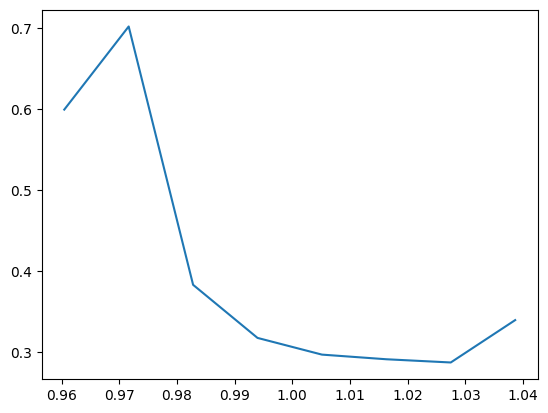

In [16]:
# model.stock.options("2025-03-28")
moyenness = strike/model.spot
plt.plot(moyenness,vol)

In [5]:
ticker = "AAPL"
stock =  yf.Ticker(ticker)

In [59]:
stock.info.get("dividendYield",0.0)

0.45

In [64]:
stock.options

('2025-03-28',
 '2025-04-04',
 '2025-04-11',
 '2025-04-17',
 '2025-04-25',
 '2025-05-02',
 '2025-05-16',
 '2025-06-20',
 '2025-07-18',
 '2025-08-15',
 '2025-09-19',
 '2025-10-17',
 '2025-12-19',
 '2026-01-16',
 '2026-03-20',
 '2026-06-18',
 '2026-12-18',
 '2027-01-15',
 '2027-06-17',
 '2027-12-17')

In [12]:
data = stock.history(period ="1y") # collection des données sur une année
log_return = np.log(data["Close"]/data["Close"].shift(-1)) # calcul de rendement sur une durée de l'annee
spot = data["Close"].iloc[-1] # spot au dernier jour

In [18]:
std_actif = log_return.std()* np.sqrt(252)
# pour caliberer le modele de BS on a juste besoin de la volatilité de sous-jacent
# le drift de sous-jacent ne rentre pas dans les calcules on retient juste le rendement de risque de la trésorie

In [87]:
expiring_date ="2025-03-28"
calls = stock.option_chain(expiring_date)
calls.calls

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,AAPL250328C00100000,2025-03-26 15:56:11+00:00,100.0,122.58,122.7,123.20,0.000000,0.000000,4.0,39,0.000010,True,REGULAR,USD
1,AAPL250328C00110000,2025-03-21 16:02:33+00:00,110.0,102.95,112.7,113.05,0.000000,0.000000,2.0,2,0.000010,True,REGULAR,USD
2,AAPL250328C00120000,2025-03-26 15:56:10+00:00,120.0,102.55,102.7,103.05,0.000000,0.000000,5.0,22,0.000010,True,REGULAR,USD
3,AAPL250328C00130000,2025-03-12 18:02:08+00:00,130.0,87.30,92.7,93.05,0.000000,0.000000,NaN,1,0.000010,True,REGULAR,USD
4,AAPL250328C00140000,2025-03-27 15:10:54+00:00,140.0,82.85,82.8,83.10,-0.200005,-0.240824,1.0,36,0.000010,True,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,AAPL250328C00310000,2025-03-05 19:52:47+00:00,310.0,0.02,0.0,0.01,0.000000,0.000000,5.0,701,1.375003,False,REGULAR,USD
62,AAPL250328C00315000,2025-03-13 13:30:04+00:00,315.0,0.01,0.0,0.01,0.000000,0.000000,1.0,248,1.437503,False,REGULAR,USD
63,AAPL250328C00320000,2025-03-05 20:06:51+00:00,320.0,0.02,0.0,0.01,0.000000,0.000000,3.0,6,1.500002,False,REGULAR,USD
64,AAPL250328C00325000,2025-03-14 17:29:04+00:00,325.0,0.01,0.0,0.01,0.000000,0.000000,100.0,213,1.562502,False,REGULAR,USD


In [6]:
log_return.std()*np.sqrt(252)

0.24456143412399833

In [7]:
dir(stock.option_chain())

['__add__',
 '__class__',
 '__class_getitem__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__match_args__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '_asdict',
 '_field_defaults',
 '_fields',
 '_make',
 '_replace',
 'calls',
 'count',
 'index',
 'puts',
 'underlying']

In [8]:
expiry_date = "2025-10-17"
call = stock.option_chain("2025-03-28").calls

In [9]:
call = call[call["volume"]>10] # on fixer le volume

In [10]:
call.columns

Index(['contractSymbol', 'lastTradeDate', 'strike', 'lastPrice', 'bid', 'ask',
       'change', 'percentChange', 'volume', 'openInterest',
       'impliedVolatility', 'inTheMoney', 'contractSize', 'currency'],
      dtype='object')

In [11]:
call

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
12,AAPL250328C00165000,2025-03-26 19:59:32+00:00,165.0,56.70,58.00,58.40,0.000000,0.000000,11.0,23,0.000010,True,REGULAR,USD
20,AAPL250328C00185000,2025-03-27 15:32:12+00:00,185.0,37.87,38.10,38.45,1.189999,3.244271,14.0,92,0.000010,True,REGULAR,USD
26,AAPL250328C00200000,2025-03-27 15:10:54+00:00,200.0,22.90,23.05,23.40,1.000000,4.566210,113.0,1433,0.000010,True,REGULAR,USD
27,AAPL250328C00202500,2025-03-27 15:03:00+00:00,202.5,20.17,20.55,20.80,-0.450001,-2.182351,16.0,277,0.000010,True,REGULAR,USD
29,AAPL250328C00207500,2025-03-27 14:54:09+00:00,207.5,14.80,15.60,15.85,0.950000,6.859204,34.0,1064,0.000010,True,REGULAR,USD
30,AAPL250328C00210000,2025-03-27 15:29:15+00:00,210.0,13.05,13.15,13.35,1.130000,9.479867,20.0,2349,0.000010,True,REGULAR,USD
31,AAPL250328C00212500,2025-03-27 15:15:12+00:00,212.5,10.51,10.75,10.95,0.910000,9.479165,77.0,4937,0.000010,True,REGULAR,USD
32,AAPL250328C00215000,2025-03-27 15:45:13+00:00,215.0,8.28,8.05,8.45,1.180000,16.619717,2531.0,6271,0.000010,True,REGULAR,USD
33,AAPL250328C00217500,2025-03-27 15:43:07+00:00,217.5,6.03,5.85,6.05,1.130000,23.061228,762.0,6581,0.177743,True,REGULAR,USD
34,AAPL250328C00220000,2025-03-27 15:48:43+00:00,220.0,3.80,3.70,3.80,0.900000,31.034477,5931.0,11724,0.208992,True,REGULAR,USD


In [55]:
for index,x in call.iterrows():
    print(x["strike"])

140.0
157.5
165.0
175.0
177.5
180.0
185.0
195.0
197.5
200.0
205.0
207.5
210.0
212.5
215.0
217.5
220.0
222.5
225.0
227.5
230.0
232.5
235.0
237.5
240.0
242.5
245.0
247.5
250.0
255.0
260.0
305.0
325.0
